In [92]:
from matplotlib import pyplot as plt
from matplotlib.gridspec import GridSpec
from scipy.stats import linregress
import numpy as np
from sklearn import datasets
import pandas as pd
from config import api_key
import requests
import json
from datetime import datetime

In [93]:
tickers = ["AAPL", "GOOG", "AMZN"]

dummy = pd.DataFrame(columns = ["ticker", "o", "c", "t"])

#create loop to run through URL & save info into lists
for name in tickers:
    base_url = f"https://api.polygon.io/v2/aggs/ticker/{name}/range/1/day/2012-01-01/2022-10-24?adjusted=true&sort=asc&limit=50000&apiKey={api_key}"
    response = requests.get(base_url).json()
    datadata = pd.json_normalize(response["results"])
    datadata["ticker"] = name
    datadata = datadata[["ticker", "o", "c", "t"]]

#print(datadata)
    dummy = pd.concat([dummy,datadata])
dummy.columns=["ticker", "open", "close", "date"]

#pd.concat([dummy,datadata],axis=0)
print(dummy.head())


  ticker     open    close           date
0   AAPL  21.2457  21.2614  1351656000000
1   AAPL  21.3650  21.3050  1351742400000
2   AAPL  21.2818  20.6000  1351828800000
3   AAPL  20.8398  20.8793  1352091600000
4   AAPL  21.0796  20.8161  1352178000000


In [94]:
#Print types
dummy.info()
#Convert unix to datetime & remove hours/miuntes
dummy['date'] = pd.to_datetime(dummy['date'],unit='ms')
dummy["date"] = pd.to_datetime(dummy["date"]).dt.date
#dummy.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7539 entries, 0 to 2512
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ticker  7539 non-null   object 
 1   open    7539 non-null   float64
 2   close   7539 non-null   float64
 3   date    7539 non-null   object 
dtypes: float64(2), object(2)
memory usage: 294.5+ KB


In [182]:
#Create copy of dummy
tickers_copy = dummy.copy(deep=True)
#delete
del tickers_copy["open"]
#tickers_copy
#Create copy of dummy for %change & $change
tickers_pctchange = tickers_copy.copy(deep=True)


#Divide dataframes into new dataframes by ticker
aapl_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AAPL"]
aapl_daily2 = pd.DataFrame(aapl_daily2)
#print(aapl_daily2.head())
amzn_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "AMZN"]
amzn_daily2 = pd.DataFrame(amzn_daily2)
#print(amzn_daily2.head())
goog_daily2 = tickers_pctchange[tickers_pctchange["ticker"] == "GOOG"]
goog_daily2 = pd.DataFrame(goog_daily2)
#print(goog_daily2.head())

#rename close as ticker to prepare to merge by date
aapl_daily2.rename(columns = {'close':'AAPL'}, inplace = True)
del aapl_daily2["ticker"]
amzn_daily2.rename(columns = {'close':'AMZN'}, inplace = True)
del amzn_daily2["ticker"]
goog_daily2.rename(columns = {'close':'GOOG'}, inplace = True)
del goog_daily2["ticker"]

#make copy for prices 
aapl_prices = aapl_daily2.copy(deep=True)
amzn_prices = amzn_daily2.copy(deep=True)
goog_prices = goog_daily2.copy(deep=True)
#print(aapl_prices)

#make copy for $ changes
aapl_bch = aapl_daily2.copy(deep=True)
amzn_bch = amzn_daiaapl_bchly2.copy(deep=True)
goog_bch = goog_daily2.copy(deep=True)
#print(goog_bch)

#calculate % change
aapl_daily2["AAPL"]=aapl_daily2["AAPL"].pct_change()*100
amzn_daily2["AMZN"]=amzn_daily2["AMZN"].pct_change()*100
goog_daily2["GOOG"]=goog_daily2["GOOG"].pct_change()*100
aapl_daily2 = aapl_daily2[["date", "AAPL"]]

#calculate $ change
aapl_bch["AAPL"]=aapl_bch["AAPL"].diff()
amzn_bch["AMZN"]=amzn_bch["AMZN"].diff()
goog_bch["GOOG"]=goog_bch["GOOG"].diff()
amzn_bch.head()
#aapl_daily2

,AMZN,date
0,NaN,2012-10-31
1,-0.0377,2012-11-01
2,0.0141,2012-11-02
3,0.0954,2012-11-05
4,0.1615,2012-11-06


In [186]:
#merge tables % change
merge_pctchange = aapl_daily2.merge(amzn_daily2, on='date', how='left')
merge_pctchange = merge_pctchange.merge(goog_daily2, on="date", how="left")
#merge_pctchange.head()

#merge tables prices 
merge_prices = aapl_prices.merge(amzn_prices, on='date', how='left')
merge_prices = merge_prices.merge(goog_prices, on="date", how="left")

#merge tables $change
merge_bch = aapl_bch.merge(amzn_bch, on='date', how='left')
merge_bch = merge_bch.merge(goog_bch, on="date", how="left")
merge_bch.head()

#reorder columns
merge_pctchange= merge_pctchange[['date','AAPL','GOOG', "AMZN"]]
merge_prices= merge_prices[['date','AAPL','GOOG', "AMZN"]]
merge_bch= merge_bch[['date','AAPL','GOOG', "AMZN"]]
#merge_bch
#merge_pctchange
aapl_bch.head()

,AAPL,date
0,NaN,2012-10-31
1,0.0436,2012-11-01
2,-0.7050,2012-11-02
3,0.2793,2012-11-05
4,-0.0632,2012-11-06


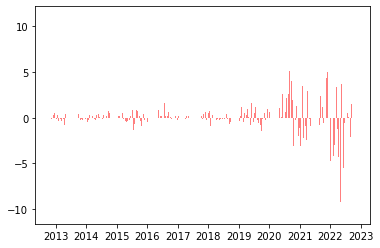

In [187]:
#plt.hist(aapl_bch["AAPL"])
#plt.bar(aapl_bch["date"], aapl_bch["AAPL"], color='r', alpha=0.5, align="center")
#plt.show()

<BarContainer object of 2513 artists>

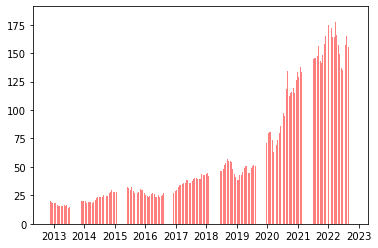

In [198]:

#plt.bar(aapl_prices["date"], aapl_prices["AAPL"], color='r', alpha=0.5, align="center")


(array([   2.,    5.,   15.,   89.,  721., 1426.,  224.,   21.,    6.,
           3.]),
 array([-12.86469763, -10.38014544,  -7.89559326,  -5.41104107,
         -2.92648888,  -0.4419367 ,   2.04261549,   4.52716768,
          7.01171986,   9.49627205,  11.98082424]),
 <a list of 10 Patch objects>)

<Figure size 432x288 with 0 Axes>

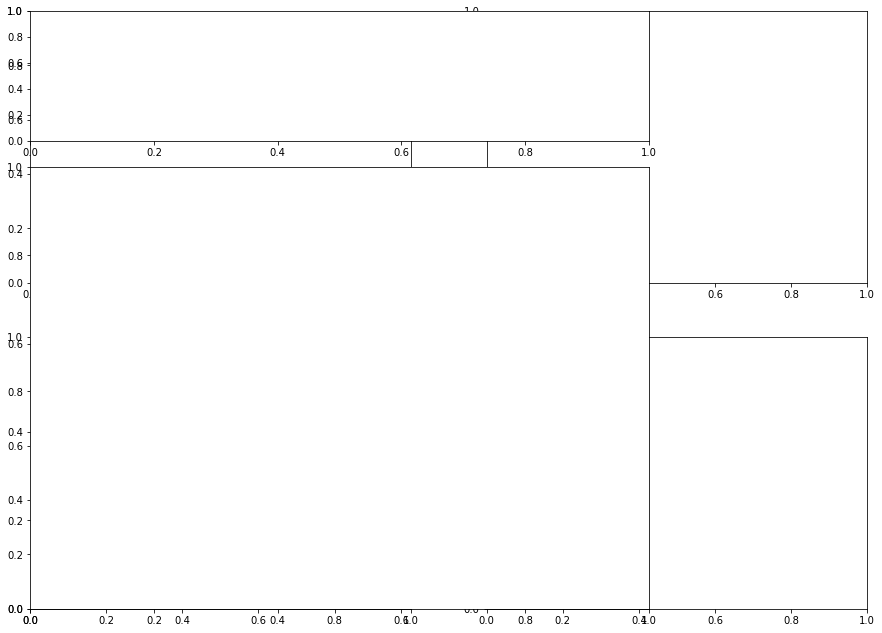

In [210]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(15,11))
gs=GridSpec(4,4)
ax_scatter=fig.add_subplot(gs[1:4, 0:3])
ax_hist_y=fig.add_subplot(gs[0,0:3])
ax_hist_x.hist(aapl_daily2["AAPL"], orientation="horizontal")


<Figure size 432x288 with 0 Axes>

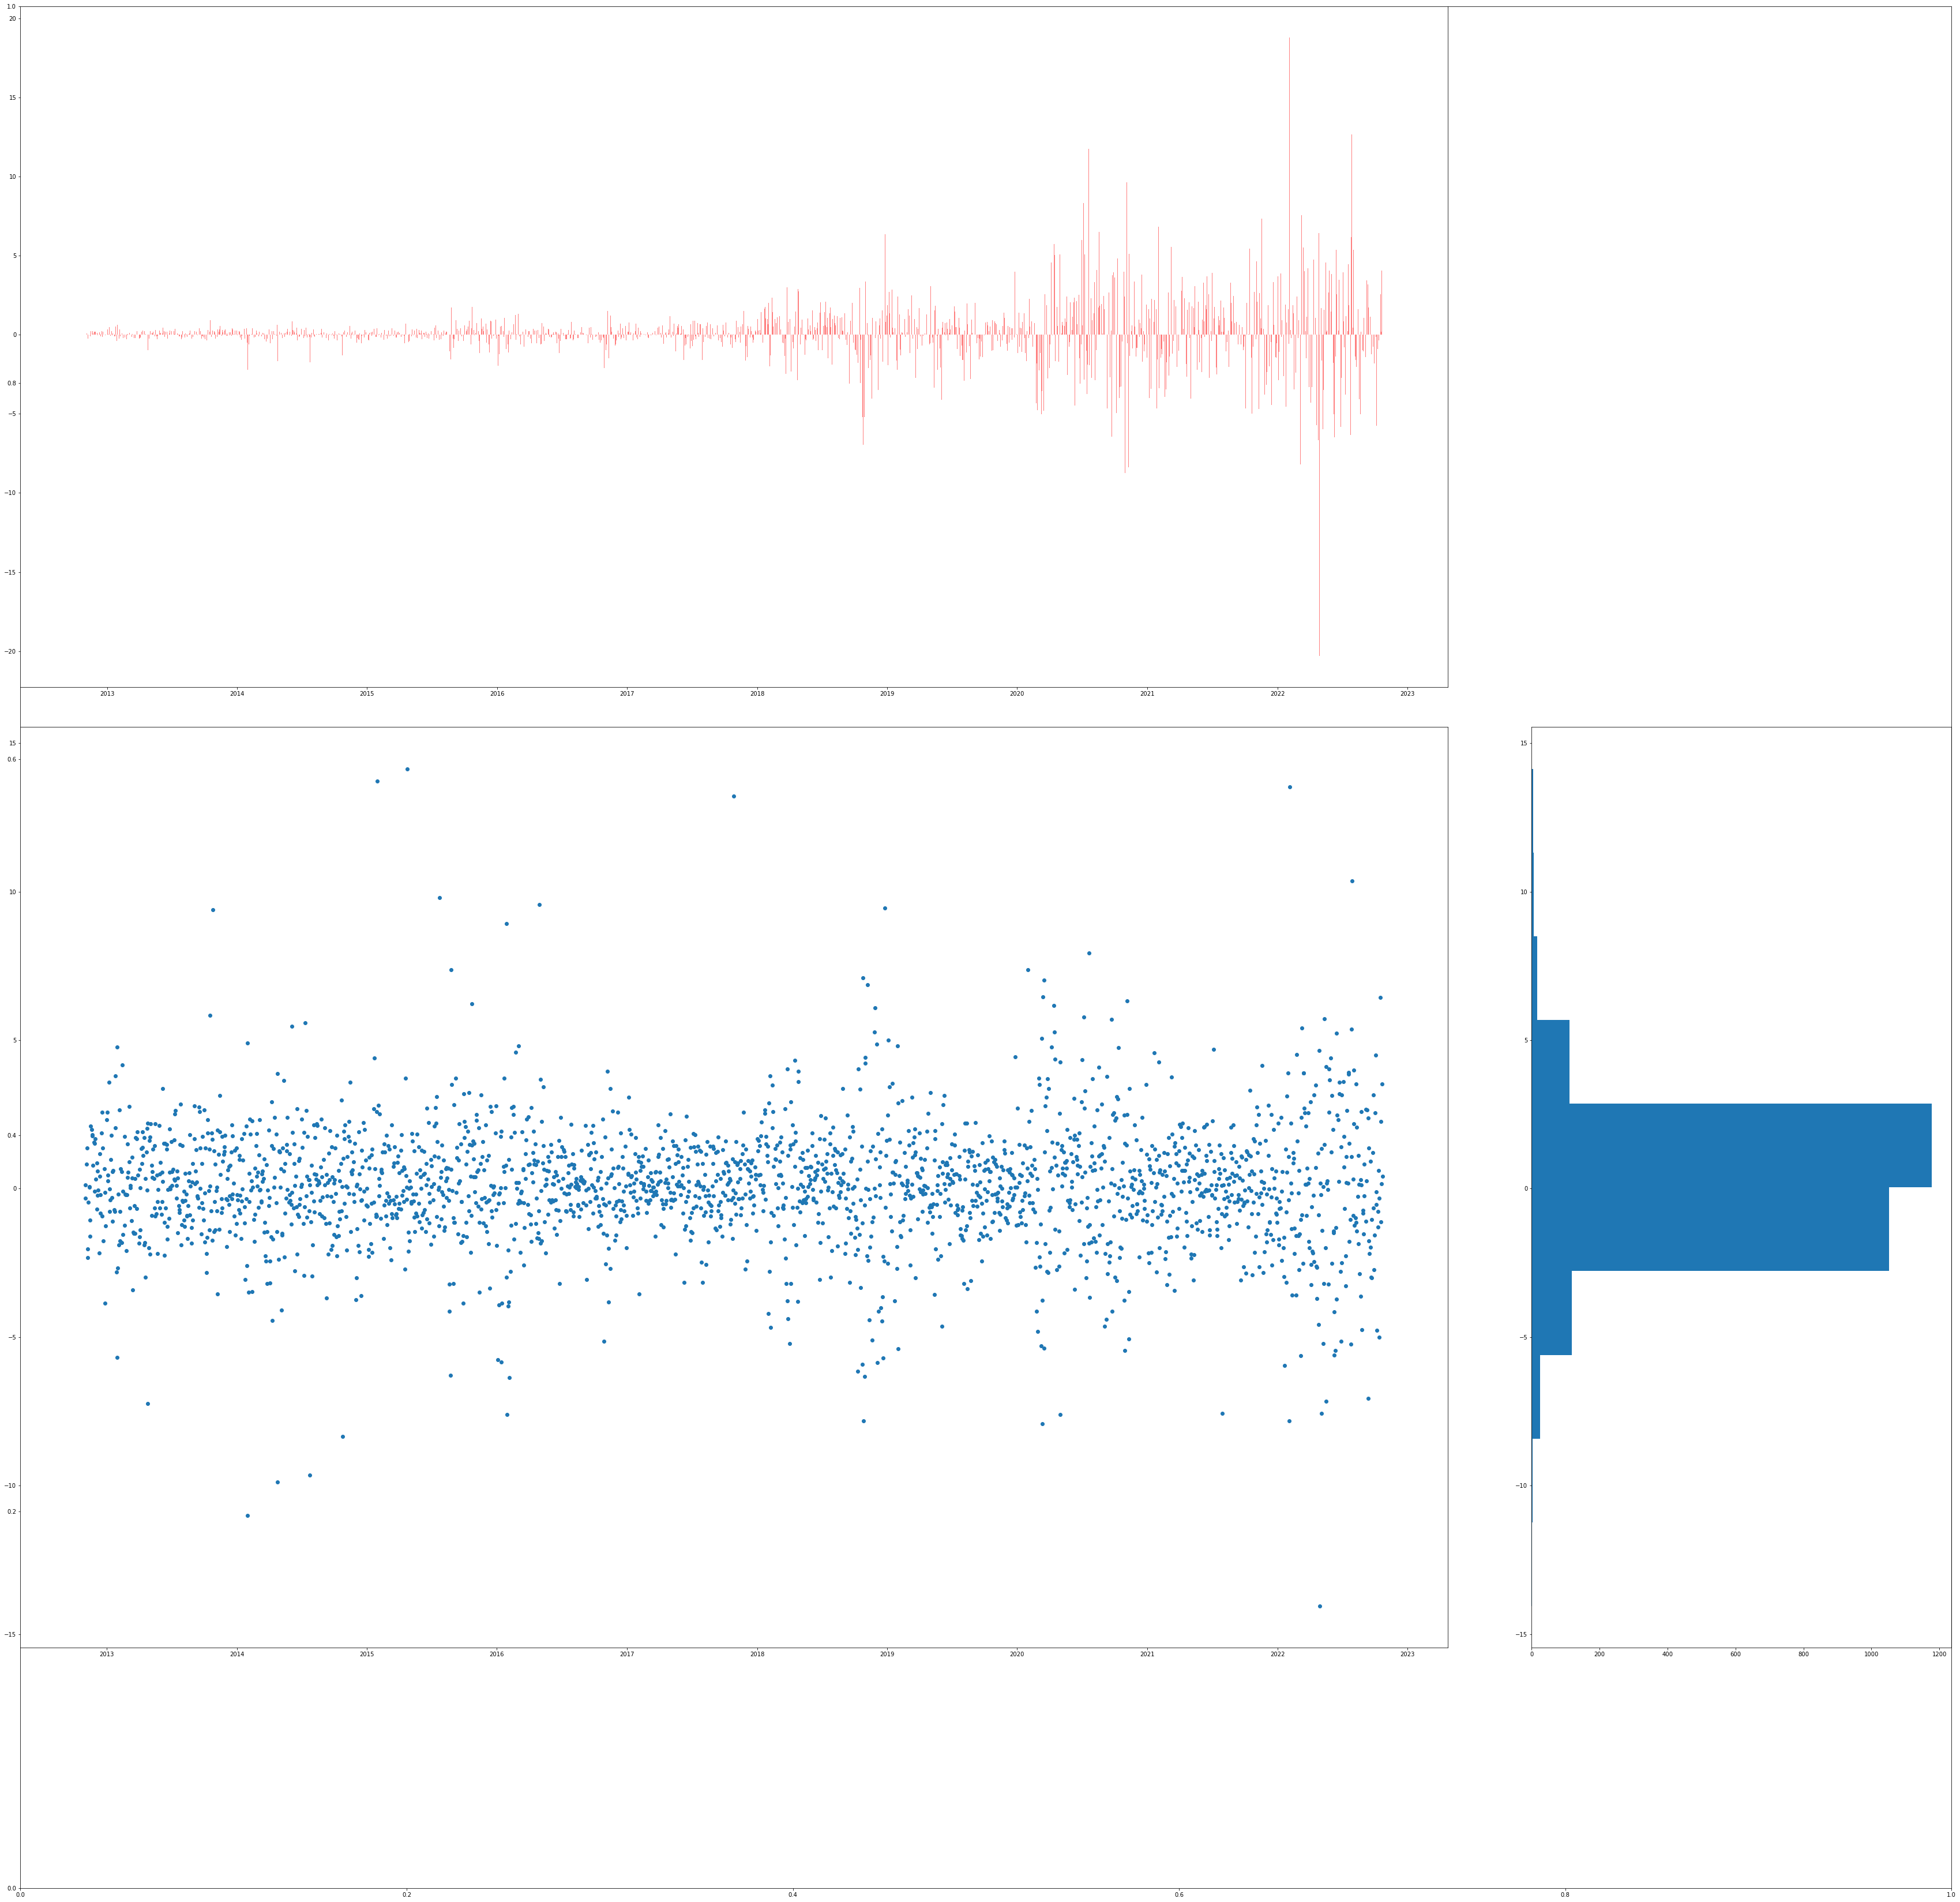

In [209]:
fig= plt.figure()
fig, ax = plt.subplots(figsize=(60,60))
gs=GridSpec(8,4)
ax_scatter=fig.add_subplot(gs[3:7, 0:3])
ax_hist_y=fig.add_subplot(gs[0:3,0:3])
ax_hist_x=fig.add_subplot(gs[3:7,3])
ax_scatter.scatter(amzn_daily2["date"], amzn_daily2["AMZN"])
ax_hist_x.hist(amzn_daily2["AMZN"], orientation="horizontal")
ax_hist_y.bar(amzn_bch["date"], amzn_bch["AMZN"], color='r', alpha=0.5, align="center")

plt.show()

<Figure size 432x288 with 0 Axes>

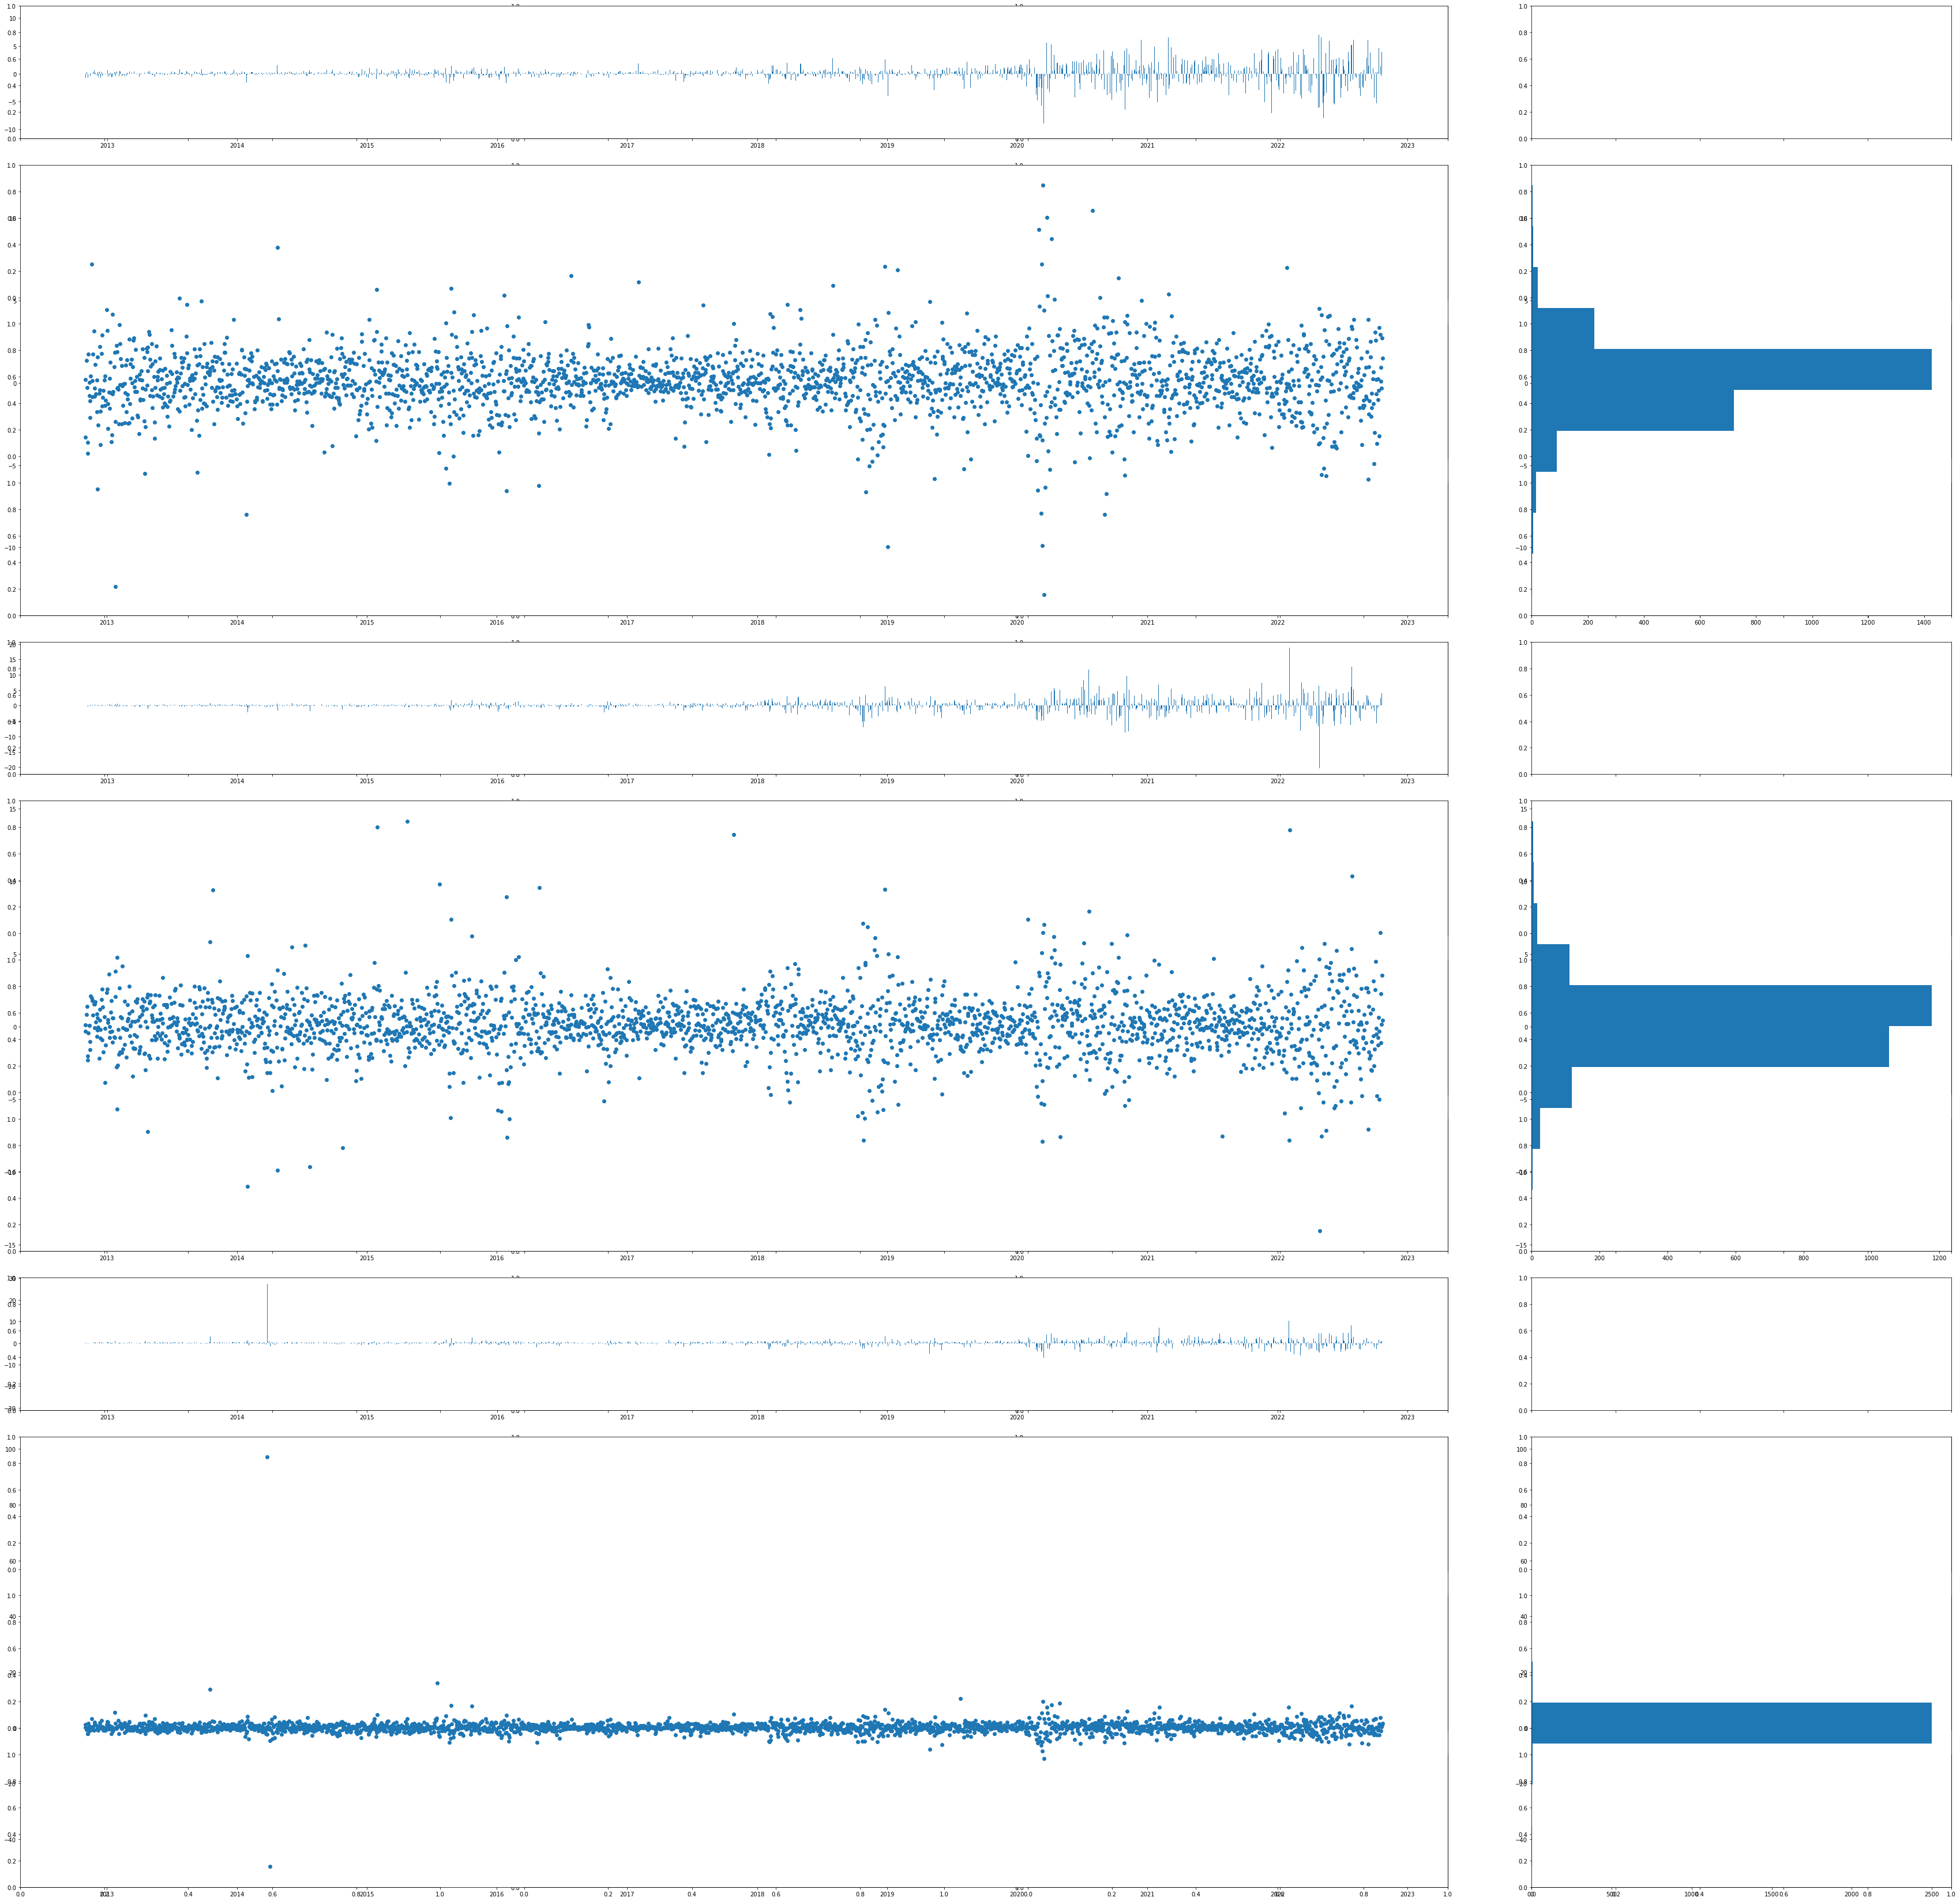

In [200]:
#Creating & plotting scatter/histogram for % &$ distribution
fig= plt.figure()
#fig, ax = plt.subplots(12, 4, figsize=(80,80))
fig, ax = plt.subplots(12,4, sharex=True, sharey=False,figsize=(60,60))
gs=GridSpec(12,4)

#AAPL subplots
ax_hist_aapl_y=fig.add_subplot(gs[0,0:3])
plt.bar(aapl_bch["date"], aapl_bch["AAPL"])
ax_scatter_aapl=fig.add_subplot(gs[1:4, 0:3])
ax_scatter_aapl.scatter(aapl_daily2["date"], aapl_daily2["AAPL"])
ax_hist_aapl_x=fig.add_subplot(gs[1:4,3])
ax_hist_aapl_x.hist(aapl_daily2["AAPL"], orientation="horizontal")
#add AMZN subplots
ax_hist_amzn_y=fig.add_subplot(gs[4,0:3])
plt.bar(amzn_bch["date"], amzn_bch["AMZN"])
ax_scatter_amzn=fig.add_subplot(gs[5:8, 0:3])
ax_scatter_amzn.scatter(amzn_daily2["date"], amzn_daily2["AMZN"])
ax_hist_amzn_x=fig.add_subplot(gs[5:8,3])
ax_hist_amzn_x.hist(amzn_daily2["AMZN"], orientation="horizontal")
#add GOOGL subplots
ax_scatter_goog=fig.add_subplot(gs[9:12, 0:3])
ax_scatter_goog.scatter(goog_daily2["date"], goog_daily2["GOOG"])
ax_hist_goog_y=fig.add_subplot(gs[8,0:3])
plt.bar(goog_bch["date"], goog_bch["GOOG"])
ax_hist_goog_x=fig.add_subplot(gs[9:12,3])
ax_hist_goog_x.hist(goog_daily2["GOOG"], orientation="horizontal")
plt.show()

In [81]:
#aapl_plot, = plt.plot(merge_pctchange["date"], merge_pctchange["AAPL"], color="blue", label="AAPL" )
#amzn, = plt.plot(merge_pctchange["date"], merge_pctchange["AMZN"], color="red", label="AMZN" )
#goog, = plt.plot(merge_pctchange["date"], merge_pctchange["GOOG"], color="green", label="GOOG" )
#plt.show()

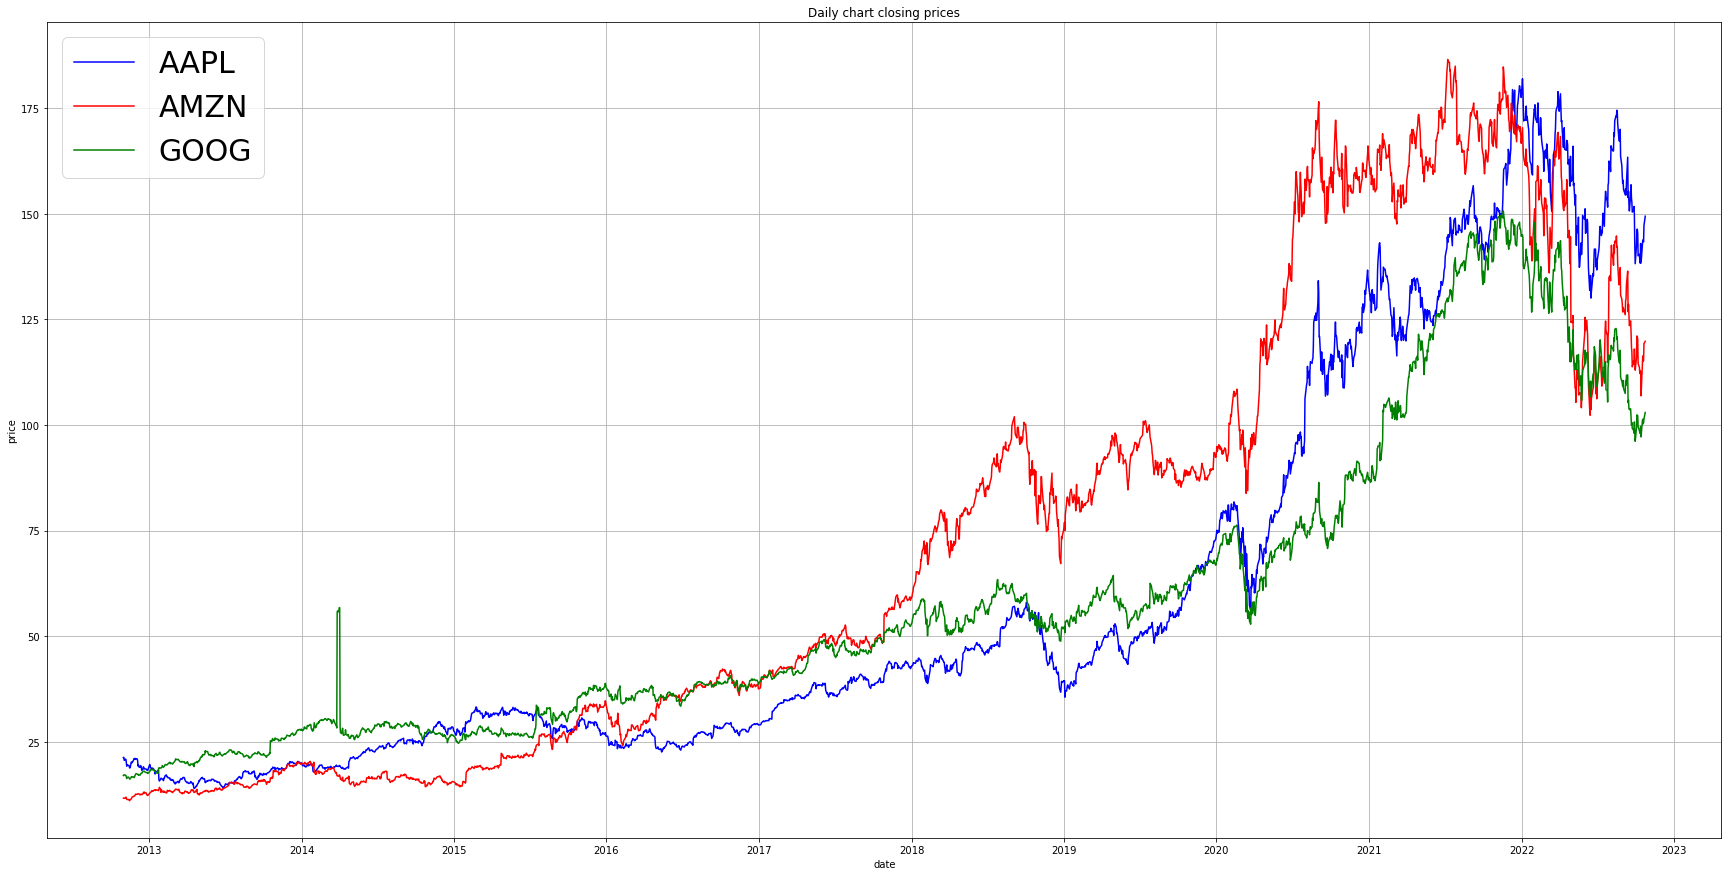

In [12]:
plt.figure(figsize=(30,15))
aapl_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AAPL"], color='blue', label="AAPL")
amzn_daily_chart, = plt.plot(merge_bch["date"], merge_bch["AMZN"], color='red', label="AMZN")
goog_daily_chart, = plt.plot(merge_bch["date"], merge_bch["GOOG"], color='green', label="GOOG")
plt.grid()
plt.xlabel("date")
plt.ylabel("price")
plt.title("Daily chart closing prices")
plt.legend(fontsize = "30",loc="upper left")

,Date,Ticker,Period,PE,PEG
0,2022-09-30,GOOG,Q3,22.496059,-1.829679
1,2022-06-30,GOOG,Q2,22.440763,-24.962599
2,2022-03-31,GOOG,Q1,28.045909,-1.417429
3,2021-12-31,GOOG,Q4,23.222970,2.403562
4,2021-09-30,GOOG,Q3,23.426947,8.722001
